# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #5
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, March 2nd, 2018 at 11:00am

**Instructions:**

- Upload your final answers in a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import time
import itertools
import functools

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('talk')
%matplotlib inline

## Problem 1: Optimization (contd)

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x  + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

### Simulated Annealing 
Implement Simulated Annealing initalized at $(\lambda_1, \lambda_2) = (-5, 0)$ to minimize our loss function $L$. Compare your results to what you obtained for gradient descent and stochastic gradient descent initialized at $(\lambda_1, \lambda_2) = (-5, 0)$.

For your Simulated Annealing implementation, we suggest *starting* with following settings for parameters (you should further experiment with and tweak these or feel free to set your own):

- Proposal distribution: bivariate normal with covariance $[[1, 0], [0, 1]]$
- Min Length: 500
- Max Temperature: 10

You should also set your own cooling schedule.

For each temperature, plot the parameters accepted or the cost function with respect to the iteration number. What is happening to the these parameters or costs over iterations? Connect the trends you observe in the visualization to the lecture on Markov Chains.

### Answer to Problem 1

In [2]:
# Load data

data = np.genfromtxt('HW3_data.csv', delimiter=',')
x = data[0, ]
y = data[1, ]

print('Number of data points: {}.'.format(len(x)))

lam_best = np.array([2.05384, 0])

Number of data points: 16000.


In [3]:
# In GD, we use the gradient of total loss at each iteration
# In SGD, we multiply the gradient by total sample size at each iteration

def L(x, y, lam):
    
    # Average loss   
    
    return np.mean(0.000045 * lam[1]**2 * y - 0.000098 * lam[0]**2 * x \
                 + 0.003926 * lam[0] * x * np.exp((y**2 - x**2) * (lam[0]**2 + lam[1]**2)))

def L_total(x, y, lam):
    
    # Average loss   
    
    return np.sum(0.000045 * lam[1]**2 * y - 0.000098 * lam[0]**2 * x \
                 + 0.003926 * lam[0] * x * np.exp((y**2 - x**2) * (lam[0]**2 + lam[1]**2)))

def dL(x, y, lam):
    
    # Gradient of total loss
    
    z = y*y - x*x
    z1 = x*np.exp((lam[0]**2+lam[1]**2)*z)
    a = np.sum(-0.000196*lam[0]*x + (0.003926+0.007852*lam[0]**2*z)*z1)
    b = np.sum(0.00009*lam[1]*y + 0.007852*lam[0]*lam[1]*z*z1)
    return np.array([a, b])

class GD:
    def __init__(self, x, y, lam_init, step=0.001, max_iter=10000, tol=0.001):
        self.name = 'Gradient Descent'
        self.x = deepcopy(x)
        self.y = deepcopy(y)
        self.m = x.size
        self.lam_init = lam_init
        self.step = step
        self.max_iter = max_iter
        self.tol = tol
        self.costs = []
        self.time_ = []
        self.total_time = 0
        self.history = []
        self.iter_ = 0
        
    def run_gd(self):
        
        # Run max_iter iterations
        
        total_start = time.time()
        self.history.append(self.lam_init)
        self.costs.append(L(self.x, self.y, self.lam_init))
        for _ in range(self.max_iter):
            start = time.time()
            self.iter_ += 1
            self.history.append(self.history[-1] - self.step * dL(self.x, self.y, self.history[-1]))
            self.costs.append(L(self.x, self.y, self.history[-1]))
            self.time_.append(time.time() - start)
        self.total_time = time.time() - total_start
        return self
    
    def run_gd_test(self, actual=np.array([2.05384, 0])):
        
        # Run until approaching actual within tol or reaching max_iter
        
        total_start = time.time()
        self.history.append(self.lam_init)
        self.costs.append(L(self.x, self.y, self.lam_init))
        for _ in range(self.max_iter):
            start = time.time()
            self.iter_ += 1
            self.history.append(self.history[-1] - self.step * dL(self.x, self.y, self.history[-1]))
            self.costs.append(L(self.x, self.y, self.history[-1]))
            if np.isnan(self.costs[-1]):
                self.time_.append(time.time() - start)
                break
            if np.linalg.norm(self.history[-1] - actual) <= self.tol:
                self.time_.append(time.time() - start)
                break
            self.time_.append(time.time() - start)
        self.total_time = time.time() - total_start
        return self

class SGD:
    def __init__(self, x, y, lam_init, step=0.001, max_epoch=5, tol=0.001):
        self.name = 'Stochastic Gradient Descent'
        self.x = deepcopy(x)
        self.y = deepcopy(y)
        self.m = x.size
        self.lam_init = lam_init
        self.step = step
        self.max_epoch = max_epoch
        self.tol = tol
        self.costs = []
        self.total_cost = 0
        self.time_ = []
        self.total_time = 0
        self.history = []
        self.iter_ = 0
    
    def run_sgd(self):
        
        # Run until reaching max_epoch
        
        total_start = time.time()
        self.costs.append(L(self.x[0], self.y[0], self.lam_init))
        self.history.append(self.lam_init)
        for _ in range(self.max_epoch):
            for i in range(self.m):
                start = time.time()
                self.iter_ += 1
                self.history.append(self.history[-1]\
                                    - self.step * self.m* dL(self.x[i], self.y[i], self.history[-1]))
                self.total_cost += L(self.x[i], self.y[i], self.history[-1])
                self.costs.append(self.total_cost / self.iter_)
                self.time_.append(time.time() - start)
            neworder = np.random.permutation(self.m)
            self.x = self.x[neworder]
            self.y = self.y[neworder]
        self.total_time = time.time() - total_start
        return self 
    
    def run_sgd_test(self, actual=np.array([2.05384, 0])):
        
        # Run until approaching actual within tol or reaching max_epoch
        
        total_start = time.time()
        self.costs.append(L(self.x[0], self.y[0], self.lam_init))
        self.history.append(self.lam_init)
        done = False
        for _ in range(self.max_epoch):
            for i in range(self.m):
                start = time.time()
                self.iter_ += 1
                self.history.append(self.history[-1]\
                                    - self.step * self.m * dL(self.x[i], self.y[i], self.history[-1]))
                self.total_cost += L(self.x[i], self.y[i], self.history[-1])
                self.costs.append(self.total_cost / self.iter_)
                if np.isnan(self.costs[-1]):
                    done = True
                    self.time_.append(time.time() - start)
                    break
                if np.linalg.norm(self.history[-1] - actual) <= self.tol:
                    done = True
                    self.time_.append(time.time() - start)
                    break
                self.time_.append(time.time() - start)
            if done:
                break
            neworder = np.random.permutation(self.m)
            self.x = self.x[neworder]
            self.y = self.y[neworder]
        self.total_time = time.time() - total_start
        return self

In [4]:
lam_init = np.array([-5, 0])
gd = GD(x, y, lam_init).run_gd_test()
sgd = SGD(x, y, lam_init).run_sgd_test()

In [5]:
class SA:
    
    # Reference: https://am207.github.io/2018spring/wiki/simanneal.html
    
    def __init__(self):
        pass
    
    def run_sa(self, energyfunc, initials, epochs, tempfunc, iterfunc, proposalfunc, verbose=False):
        start = time.time()
        accumulator = []
        self.initials = initials
        best_solution = old_solution = initials['solution']
        T = initials['T']
        length = initials['length']
        T_index = [(0, length)]
        best_energy = old_energy = energyfunc(old_solution)
        accepted = 0
        total = 0
        for ind in range(epochs):
            if verbose:
                print('Epoch', ind + 1)
            if ind > 0:
                T = tempfunc(T)
                length = iterfunc(length)
                T_index.append((T_index[-1][1], T_index[-1][1] + length))
            if verbose:
                print('Temperature', T, 'Length', length)
            for i in range(length):
                total += 1
                new_solution = proposalfunc(old_solution)
                new_energy = energyfunc(new_solution)
                alpha = min(1, np.exp((old_energy - new_energy) / T))
                if ((new_energy < old_energy) or (np.random.uniform() < alpha)):
                    accepted += 1
                    accumulator.append((T, new_solution, new_energy))
                    if new_energy < best_energy:
                        best_energy = new_energy
                        best_solution = new_solution
                        best_index = total
                        best_temp = T
                    old_energy = new_energy
                    old_solution = new_solution
                else:
                    accumulator.append((T, old_solution, old_energy))
            if verbose:
                print('Best T', best_temp, 'Best solution', best_solution, \
                      'Best energy', best_energy)
        self.accumulator = accumulator
        self.T_index = T_index
        self.best_meta = dict(index=best_index, temp=best_temp)
        self.best_solution = best_solution
        self.best_energy = best_energy
        self.accepted = accepted
        self.total = total
        print('Frac accepted', accepted / total, 'Total iterations', total, 'Best meta', self.best_meta)
        self.total_time = time.time() - start
        return self

After several trials, we decide to set proposal distribution as bivariate normal with covariance [[1.2, 0], [0, 1.2]], min length as 500, and max temperature as 10.

We decrease the temperature by 20% and increase the length by 20% at each epoch.

In [6]:
ef = functools.partial(L_total, x, y)

def tf(T):
    return 0.8 * T

def itf(length):
    return int(np.ceil(1.2 * length))

def pf(lam):
    return np.random.multivariate_normal(lam, cov=[[1.5, 0], [0, 1.5]])

inits = dict(solution=np.array([-5, 0]), length=500, T=10)
epochs = 20

In [7]:
sa = SA().run_sa(ef, inits, epochs, tf, itf, pf, verbose=True)

Epoch 1
Temperature 10 Length 500
Best T 10 Best solution [ 2.17002534  0.23011703] Best energy -9.83260666308
Epoch 2
Temperature 8.0 Length 600
Best T 8.0 Best solution [ 2.11755422 -0.07839078] Best energy -9.91605198318
Epoch 3
Temperature 6.4 Length 720
Best T 6.4 Best solution [ 2.07636303 -0.05547057] Best energy -9.92889232722
Epoch 4
Temperature 5.120000000000001 Length 864
Best T 6.4 Best solution [ 2.07636303 -0.05547057] Best energy -9.92889232722
Epoch 5
Temperature 4.096000000000001 Length 1037
Best T 4.096000000000001 Best solution [ 2.07420924 -0.00942663] Best energy -9.93294630497
Epoch 6
Temperature 3.276800000000001 Length 1245
Best T 4.096000000000001 Best solution [ 2.07420924 -0.00942663] Best energy -9.93294630497
Epoch 7
Temperature 2.621440000000001 Length 1494
Best T 4.096000000000001 Best solution [ 2.07420924 -0.00942663] Best energy -9.93294630497
Epoch 8
Temperature 2.097152000000001 Length 1793
Best T 4.096000000000001 Best solution [ 2.07420924 -0.00942

We can compare the result of simulated annealing with that of GD and SGD from the same initial point.

In [8]:
print('Simulated annealing')
print('Final lambda: {}'.format(sa.best_solution))
print('L2 distance to the actual optimum: {}'.format(np.linalg.norm(sa.best_solution - lam_best)))
print('Final total loss on the entire dataset: {}'.format(sa.best_energy))
print()

print('Gradient descent')
print('Final lambda: {}'.format(gd.history[-1]))
print('L2 distance to the actual optimum: {}'.format(np.linalg.norm(gd.history[-1] - lam_best)))
print('Final total loss on the entire dataset: {}'.format(L_total(x, y, gd.history[-1])))
print()

print('Gradient descent')
print('Final lambda: {}'.format(sgd.history[-1]))
print('L2 distance to the actual optimum: {}'.format(np.linalg.norm(sgd.history[-1] - lam_best)))
print('Final total loss on the entire dataset: {}'.format(L_total(x, y, sgd.history[-1])))
print()

Simulated annealing
Final lambda: [ 2.05302754  0.00520398]
L2 distance to the actual optimum: 0.005267016991731391
Final total loss on the entire dataset: -9.934067731150435

Gradient descent
Final lambda: [-5.36324925  0.        ]
L2 distance to the actual optimum: 7.417089249485938
Final total loss on the entire dataset: 8.161528699583187

Gradient descent
Final lambda: [ 2.05364425  0.        ]
L2 distance to the actual optimum: 0.0001957475651179763
Final total loss on the entire dataset: -9.934103919875724



As we can see, simulated annealing managed to find a solution very close to the actual global optimum, while gradient descent was "trapped" to another local optimum and stochastic gradient descent managed to "bump into" the global optimum (since we were cheating here by setting the actual global optimum).

For the visualization of the parameters and the cost function with respect to the iteration number for each temperature, we plot iteration number in linear (left) and log (right) scales as shown below.

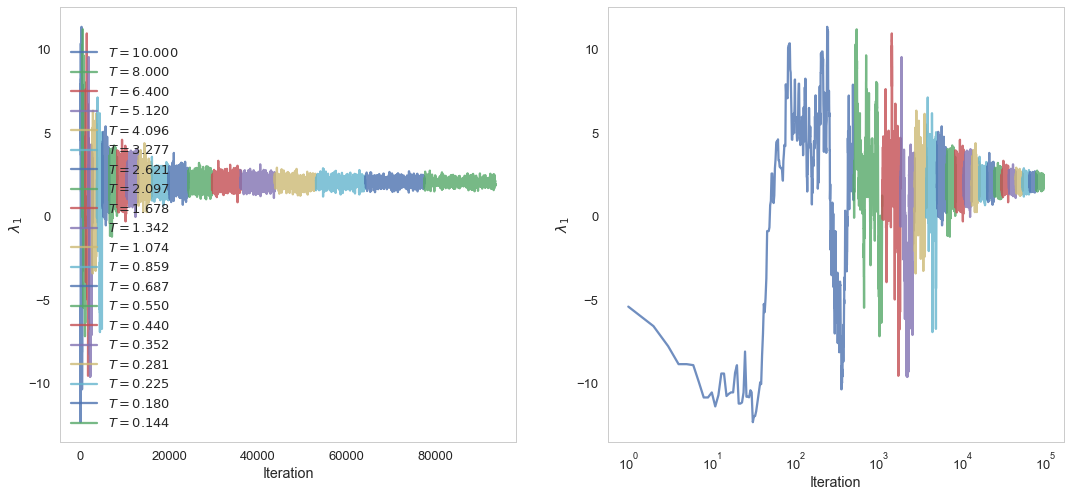

In [9]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
for i_start, i_end in sa.T_index:
    plt.plot(range(i_start + 1, i_end + 1), [v[1][0] for v in sa.accumulator[i_start:i_end]], alpha=0.8, \
            label='$T = {:.3f}$'.format(sa.accumulator[i_start][0]))
#plt.xscale('log');
plt.xlabel('Iteration');
plt.ylabel('$\lambda_1$');
plt.legend();

plt.subplot(1, 2, 2)
for i_start, i_end in sa.T_index:
    plt.plot(range(i_start + 1, i_end + 1), [v[1][0] for v in sa.accumulator[i_start:i_end]], alpha=0.8, \
            label='$T = {:.3f}$'.format(sa.accumulator[i_start][0]))
plt.xscale('log');
plt.xlabel('Iteration');
plt.ylabel('$\lambda_1$');

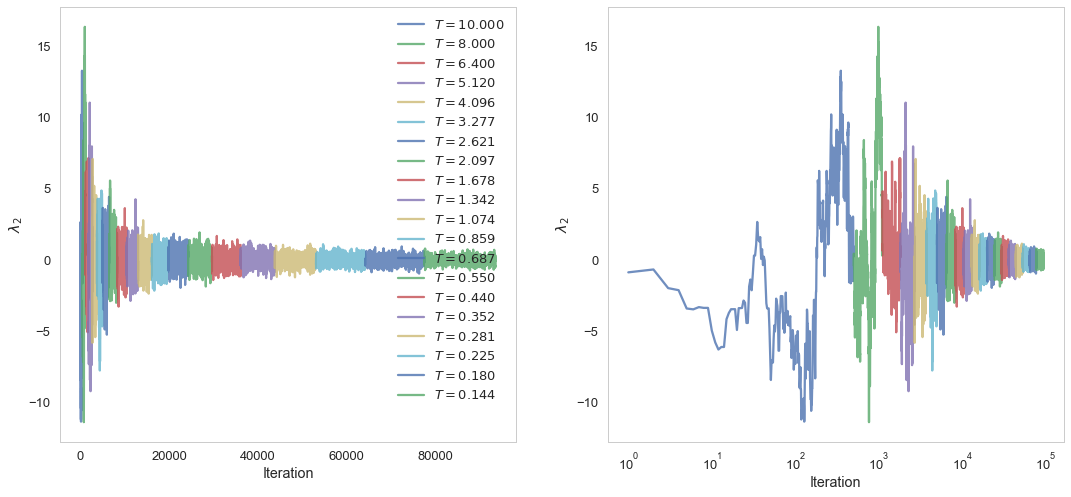

In [10]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
for i_start, i_end in sa.T_index:
    plt.plot(range(i_start + 1, i_end + 1), [v[1][1] for v in sa.accumulator[i_start:i_end]], alpha=0.8, \
            label='$T = {:.3f}$'.format(sa.accumulator[i_start][0]))
#plt.xscale('log');
plt.xlabel('Iteration');
plt.ylabel('$\lambda_2$');
plt.legend();

plt.subplot(1, 2, 2)
for i_start, i_end in sa.T_index:
    plt.plot(range(i_start + 1, i_end + 1), [v[1][1] for v in sa.accumulator[i_start:i_end]], alpha=0.8, \
            label='$T = {:.3f}$'.format(sa.accumulator[i_start][0]))
plt.xscale('log');
plt.xlabel('Iteration');
plt.ylabel('$\lambda_2$');

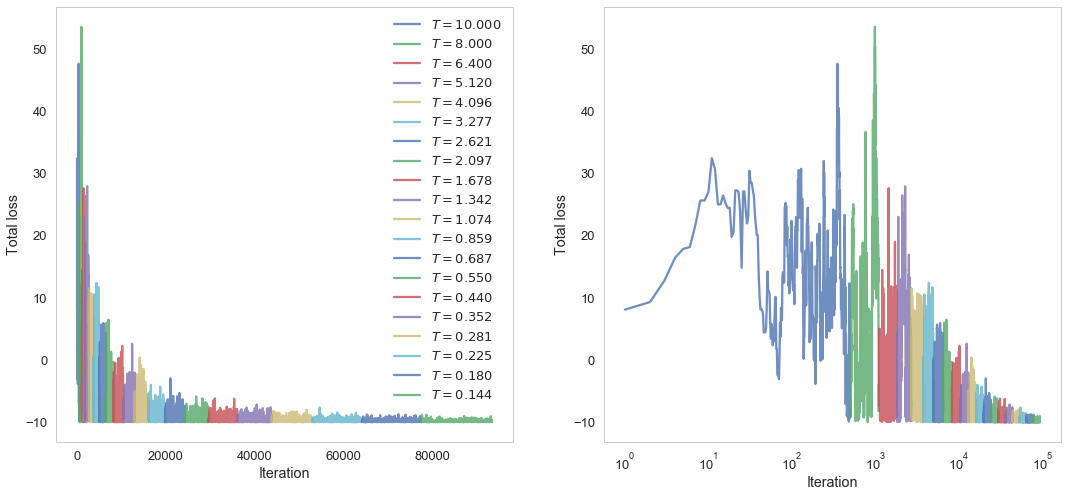

In [11]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
for i_start, i_end in sa.T_index:
    plt.plot(range(i_start + 1, i_end + 1), [v[2] for v in sa.accumulator[i_start:i_end]], alpha=0.8, \
            label='$T = {:.3f}$'.format(sa.accumulator[i_start][0]))
#plt.xscale('log');
plt.xlabel('Iteration');
plt.ylabel('Total loss');
plt.legend();

plt.subplot(1, 2, 2)
for i_start, i_end in sa.T_index:
    plt.plot(range(i_start + 1, i_end + 1), [v[2] for v in sa.accumulator[i_start:i_end]], alpha=0.8, \
            label='$T = {:.3f}$'.format(sa.accumulator[i_start][0]))
plt.xscale('log');
plt.xlabel('Iteration');
plt.ylabel('Total loss');
#plt.legend();

The fluctuation of parameters and cost function decrease as the temperature decreases. Simulated annealing can be viewed as a single inhomogeneous markov chain or a set of homogeneous markove chains, one at each temperature. Parameters can be viewed as states; iterations accepting proposed parameters can be viewed as transitions to new states; iterations rejecting proposed parameters can be viewed as transitions through edges connecting to themselves.

The detailed balance condition satisfied by our proposal ensures that the sequence generated by simulated annealing is a stationary markov chain with the boltzmann distribution as the stationary distribution of the chain as $t \to \infty$. We observed a tigher and tigher stationary distribution for the parameters about the optimum as the temperature decreases, indicating the parameters are able to escape the "trap" of other local optima at high temperature in the first few epochs, and would converge to the global optimum as $t \to \infty$.

## Problem 2: A Tired Salesman

In the famous traveling salesman problem, the quality of the solution can be measured in 
different ways, beyond finding the shortest path.  For example, the total time of travel may also be important, and may depend on the means of transportation that connect pairs of 
cities.  Consider a random distribution of $N$ points on a plane representing the cities 
that must be visited by the traveling salesman.  Each point is an (x,y) coordinate where both x and y are integers in the range [1, 50). Assign a value $s_i$ where $i\in [1,\dots,N]$ to each city that represents its size measured by population.  Let $\forall s_i, \  s_i \in [1, 10)$.  If two cities are farther away from each other than a **distance threshold of 10** and both have populations greater than a **population threshold of 5** assume there is a flight connection between them.  In all other cases assume that our poor salesman would have to drive between cities. Flying is faster than driving by a factor of 10. 

1. Use Simulated Annealing to find solutions to the traveling salesman problem for 
$N=100$, optimizing the travel path for the total distance travelled (but keeping track 
of the time of travel). 

2. Now redo the problem by optimizing the the path for the total time of travel (but keeping track of the distance traveled). Are the two solutions similar or different? 

3. How do your results change if the population and distance thresholds for the exisitence of a flight between two cities are altered?


### Answer to Problem 2

In [2]:
class Map:
    def __init__(self, N=100, seed=99, dist_thres=10, pop_thres=5, factor=10):
        self.N = N
        self.seed = seed
        self.dist = - np.ones((N, N))
        self.time_ = - np.ones((N, N))
        self.dist_thres = dist_thres
        self.pop_thres = pop_thres
        self.factor = factor
    
    def create_cities(self, c_range=[1, 50], s_range=[1, 10], seed=None):
        if seed is None:
            seed = self.seed
        np.random.seed(seed)
        self.coords = np.random.randint(low=c_range[0], high=c_range[1], size=(self.N, 2))
        self.sizes = np.random.rand(self.N) * (s_range[1] - s_range[0]) + s_range[0]
        return self
    
    def get_costs(self, i, j):
        if self.dist[i, j] < 0:
            self.dist[i, j] = self.dist[j, i] = np.sqrt(np.sum(np.square(self.coords[i] - self.coords[j])))
            if (self.sizes[i] > self.pop_thres) and (self.sizes[j] > self.pop_thres) \
            and (self.dist[i, j] > self.dist_thres):
                self.time_[i, j] = self.time_[j, i] = self.dist[i, j]
            else:
                self.time_[i, j] = self.time_[j, i] = self.factor * self.dist[i, j]
        return self.dist[i, j], self.time_[i, j]
    
    def plot_cities(self):
        # Large cities (size > population threshold) are represented by large blue dots
        # Small cities (size <= population threshold) are represented by small blue dots
        plt.plot([p[0] for p in self.coords[self.sizes > self.pop_thres]], \
                 [p[1] for p in self.coords[self.sizes > self.pop_thres]], 'bo')
        plt.plot([p[0] for p in self.coords[self.sizes <= self.pop_thres]], \
                 [p[1] for p in self.coords[self.sizes <= self.pop_thres]], 'b.')
        plt.axis('off')
        plt.axis('equal')
        
    def plot_tour(self, tour):
        # Flights are represented by green lines
        # Drivings are represented by red lines
        init_tour(self, tour)
        for i in range(len(tour)):
            if self.time_[tour[i], tour[i-1]] > self.dist[tour[i], tour[i-1]]:
                plt.plot([self.coords[tour[i]][0], self.coords[tour[i-1]][0]], \
                         [self.coords[tour[i]][1], self.coords[tour[i-1]][1]], 'r-', alpha=0.3)
            else:
                plt.plot([self.coords[tour[i]][0], self.coords[tour[i-1]][0]], \
                         [self.coords[tour[i]][1], self.coords[tour[i-1]][1]], 'g-', alpha=0.3)
        plt.plot([self.coords[tour[0]][0]], [self.coords[tour[0]][1]], 'rs', alpha=0.5)
        plt.axis('off')
        plt.axis('equal')
    
def init_tour(map_, tour):
    if len(tour) != map_.N or set(tour) != set(range(map_.N)):
        raise ValueError('Invalid tour.')
    tour = tour.copy()
    costs = np.array([map_.get_costs(tour[i], tour[i-1]) for i in range(len(tour))])
    return np.sum(costs, axis=0)
    
def change_tour(map_, old_tour, old_costs):
    #np.random.seed()
    c1 = np.random.randint(low=0, high=len(old_tour))
    c2 = np.random.randint(low=0, high=len(old_tour))
    new_tour = old_tour.copy()
    new_tour[c1], new_tour[c2] = new_tour[c2], new_tour[c1]
    
    new_costs = old_costs.copy()
    new_costs -= np.array(map_.get_costs(old_tour[c1], old_tour[c1 - 1]))
    new_costs -= np.array(map_.get_costs(old_tour[c1], old_tour[(c1 + 1) % len(old_tour)]))
    new_costs -= np.array(map_.get_costs(old_tour[c2], old_tour[c2 - 1]))
    new_costs -= np.array(map_.get_costs(old_tour[c2], old_tour[(c2 + 1) % len(old_tour)]))
    
    new_costs += np.array(map_.get_costs(new_tour[c1], new_tour[c1 - 1]))
    new_costs += np.array(map_.get_costs(new_tour[c1], new_tour[(c1 + 1) % len(new_tour)]))
    new_costs += np.array(map_.get_costs(new_tour[c2], new_tour[c2 - 1]))
    new_costs += np.array(map_.get_costs(new_tour[c2], new_tour[(c2 + 1) % len(new_tour)]))
    
    return new_tour, new_costs

We can create 100 cities as follows.

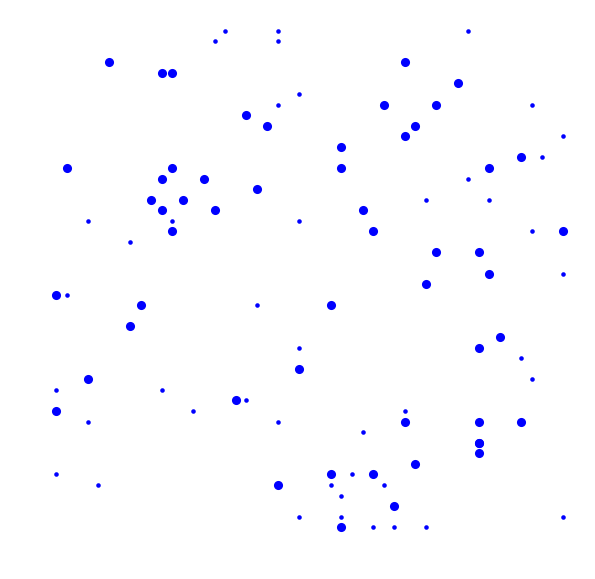

In [3]:
m = Map().create_cities()
plt.figure(figsize=(10, 10))
m.plot_cities()

Large cities are represented by large circles; small cities are represented by small dots.

In [4]:
class SA_TSP:
    def __init__(self, map_, energy_ind=0):
        
        # energy_ind
        # 0: total distance traveled
        # 1: total time of trave
        self.map_ = map_
        self.energy_ind = energy_ind
    
    def run_sa(self, init_energy, initials, epochs, tempfunc, iterfunc, proposalfunc, verbose=False):
        energy_ind = self.energy_ind
        start = time.time()
        accumulator = []
        self.initials = initials
        best_solution = old_solution = initials['solution']
        T = initials['T']
        length = initials['length']
        T_index = [(0, length)]
        Ts = []
        best_energy = old_energy = init_energy(old_solution)
        accepted = 0
        total = 0
        for ind in range(epochs):
            if verbose:
                print('Epoch', ind + 1)
            if ind > 0:
                T = tempfunc(T)
                length = iterfunc(length)
                T_index.append((T_index[-1][1], T_index[-1][1] + length))
            if verbose:
                print('Temperature', T, 'Length', length)
            for i in range(length):
                total += 1
                new_solution, new_energy = proposalfunc(old_solution, old_energy)
                alpha = min(1, np.exp((old_energy[energy_ind] - new_energy[energy_ind]) / T))
                if ((new_energy[energy_ind] < old_energy[energy_ind]) or (np.random.uniform() < alpha)):
                    accepted += 1
                    Ts.append(T)
                    accumulator.append(new_energy)
                    if new_energy[energy_ind] < best_energy[energy_ind]:
                        best_energy = new_energy
                        best_solution = new_solution
                        best_index = total
                        best_temp = T
                    old_energy = new_energy
                    old_solution = new_solution
                else:
                    Ts.append(T)
                    accumulator.append(old_energy)
            if verbose:
                print('Best T', best_temp, \
                      'Best energy', best_energy)
        self.Ts = np.array(Ts)
        self.accumulator = np.array(accumulator)
        self.T_index = T_index
        self.best_meta = dict(index=best_index, temp=best_temp)
        self.best_solution = best_solution
        self.best_energy = best_energy
        self.accepted = accepted
        self.total = total
        print('Frac accepted', accepted / total, 'Total iterations', total, 'Best meta', self.best_meta)
        self.total_time = time.time() - start
        return self

#### Problem 2.1

After several trials, we decide to set min length as 100, max temperature as 80. We decrease the temperature by 10% and increase the length by 20% at each epoch.

We are able to get a reasonably good result after running 50 epochs.

In [5]:
%%time

N = 100
m = Map(N).create_cities()

ef = functools.partial(init_tour, m)

def tf(T):
    return 0.9 * T

def itf(length):
    return int(np.ceil(1.2 * length))

pf = functools.partial(change_tour, m)

inits = dict(solution=list(range(N)), length=100, T=80)
epochs = 50

#np.random.seed()
tsp1 = SA_TSP(m, 0).run_sa(ef, inits, epochs, tf, itf, pf, verbose=True)

Epoch 1
Temperature 80 Length 100
Best T 80 Best energy [  2302.4179186  18090.5476194]
Epoch 2
Temperature 72.0 Length 120
Best T 72.0 Best energy [  2238.20135423  17936.22480036]
Epoch 3
Temperature 64.8 Length 144
Best T 64.8 Best energy [  2205.99876484  16629.83879415]
Epoch 4
Temperature 58.32 Length 173
Best T 58.32 Best energy [  2131.69481168  17209.48421083]
Epoch 5
Temperature 52.488 Length 208
Best T 58.32 Best energy [  2131.69481168  17209.48421083]
Epoch 6
Temperature 47.239200000000004 Length 250
Best T 47.239200000000004 Best energy [  2065.37117713  16989.54231986]
Epoch 7
Temperature 42.515280000000004 Length 300
Best T 42.515280000000004 Best energy [  2029.60039322  15113.55836796]
Epoch 8
Temperature 38.263752000000004 Length 360
Best T 38.263752000000004 Best energy [  1993.46662424  16670.24060283]
Epoch 9
Temperature 34.4373768 Length 432
Best T 34.4373768 Best energy [  1989.29637241  14999.87173344]
Epoch 10
Temperature 30.993639120000005 Length 519
Best T 3

We can plot the total distance traveled, as well as total time of travel, over iterations as follows.

Wall time: 2.34 s


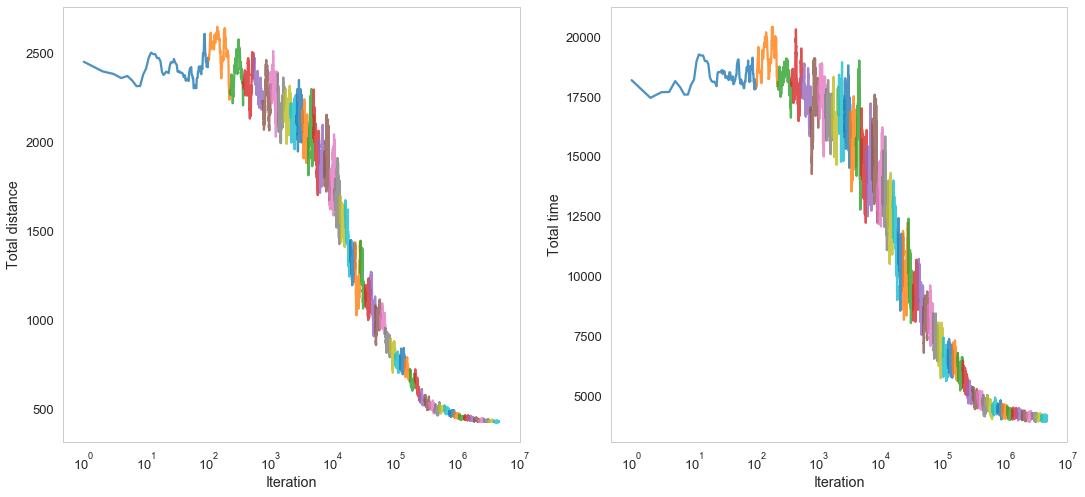

In [6]:
%%time

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)

for i_start, i_end in tsp1.T_index:
    plt.plot(range(i_start + 1, i_end + 1), tsp1.accumulator[i_start:i_end, 0], alpha=0.8)
plt.xscale('log');
plt.xlabel('Iteration');
plt.ylabel('Total distance');

plt.subplot(1, 2, 2)
for i_start, i_end in tsp1.T_index:
    plt.plot(range(i_start + 1, i_end + 1), tsp1.accumulator[i_start:i_end, 1], alpha=0.8)
plt.xscale('log');
plt.xlabel('Iteration');
plt.ylabel('Total time');

Observations:
1. Both total distance and total time decrease over iterations, and seem to converge in the end. 
2. The fluctuations decrease as the temperature decreases. 
3. The percentage of decrease in total distance is higher than that in total time.

We can visualize the solution on the city map as follows. Large cities are represented by large circles, and small cities are represented by small dots. Starting point is indicated by a red square. Drivings are represented by red lines and flights are represented by green lines.

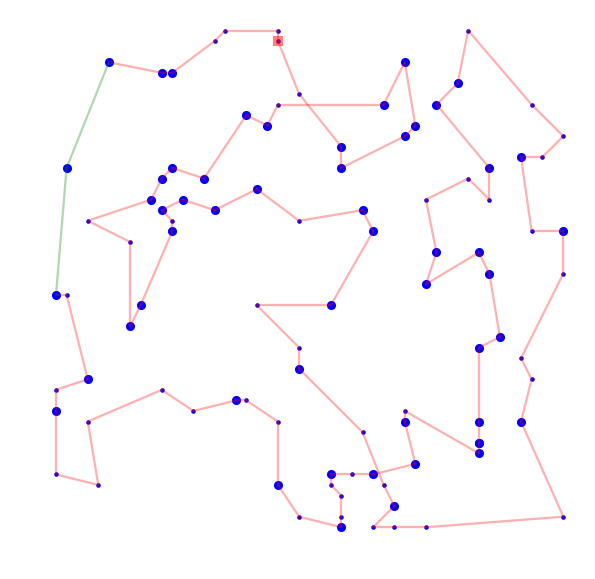

In [7]:
plt.figure(figsize=(10, 10))
tsp1.map_.plot_cities()
tsp1.map_.plot_tour(tsp1.best_solution)

Observations:
1. The solution is dominated by drivings instead of flights.
2. The solution is dominated by short paths and there are few intersections.

The solution looks reasonable since we are optimizing for the total distance tranveled.

#### Problem 2.2

In this case, we are supposed to increase the max temperature since the value of the total time is generally an order of magnitude higher than that of the total distance.

After several trials, we max temperature as 500 and min length as 100. We decrease the temperature by 10% and increase the length by 20% at each epoch.

We are able to get a reasonably good result after running 50 epochs.

Basically, we use the same cooling schedule and initialization as the previous part, except the max temperature.

In [8]:
%%time

N = 100
m = Map(N).create_cities()

ef = functools.partial(init_tour, m)

def tf(T):
    return 0.9 * T

def itf(length):
    return int(np.ceil(1.2 * length))

pf = functools.partial(change_tour, m)

inits = dict(solution=list(range(N)), length=100, T=500)
epochs = 50

#np.random.seed()
tsp2 = SA_TSP(m, 1).run_sa(ef, inits, epochs, tf, itf, pf, verbose=True)

Epoch 1
Temperature 500 Length 100
Best T 500 Best energy [  2341.74750431  16439.16422592]
Epoch 2
Temperature 450.0 Length 120
Best T 450.0 Best energy [  2272.62061649  15844.90612818]
Epoch 3
Temperature 405.0 Length 144
Best T 405.0 Best energy [  2297.50844466  14541.91137833]
Epoch 4
Temperature 364.5 Length 173
Best T 405.0 Best energy [  2297.50844466  14541.91137833]
Epoch 5
Temperature 328.05 Length 208
Best T 405.0 Best energy [  2297.50844466  14541.91137833]
Epoch 6
Temperature 295.245 Length 250
Best T 295.245 Best energy [  2086.09475493  14269.47972204]
Epoch 7
Temperature 265.7205 Length 300
Best T 265.7205 Best energy [  2073.45559606  12855.18660389]
Epoch 8
Temperature 239.14845000000003 Length 360
Best T 239.14845000000003 Best energy [  2066.55282596  12736.91677083]
Epoch 9
Temperature 215.23360500000004 Length 432
Best T 239.14845000000003 Best energy [  2066.55282596  12736.91677083]
Epoch 10
Temperature 193.71024450000004 Length 519
Best T 193.71024450000004 

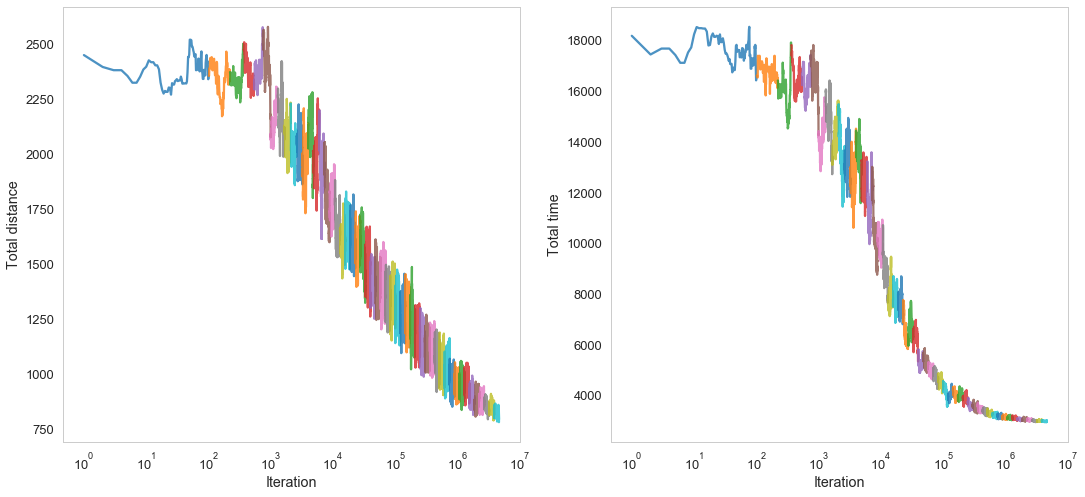

In [9]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)

for i_start, i_end in tsp2.T_index:
    plt.plot(range(i_start + 1, i_end + 1), tsp2.accumulator[i_start:i_end, 0], alpha=0.8)
plt.xscale('log');
plt.xlabel('Iteration');
plt.ylabel('Total distance');

plt.subplot(1, 2, 2)
for i_start, i_end in tsp2.T_index:
    plt.plot(range(i_start + 1, i_end + 1), tsp2.accumulator[i_start:i_end, 1], alpha=0.8)
plt.xscale('log');
plt.xlabel('Iteration');
plt.ylabel('Total time');

Observations:
1. Both total distance and total time decrease over iterations. While total time seems to converge in the end, total distance seems to converge much slower. 
2. The fluctuations decrease as the temperature decreases. 
3. The percentage of decrease in total distance is lower than that in total time, which is opposite to the observation in the previous part.
4. The final total distance is much higher than that in the previous part, while the final total time is much lower.

We can visualize the solution on the city map. Large cities are represented by large circles, and small cities are represented by small dots. Starting point is indicated by a red square. Drivings are represented by red lines and flights are represented by green lines.

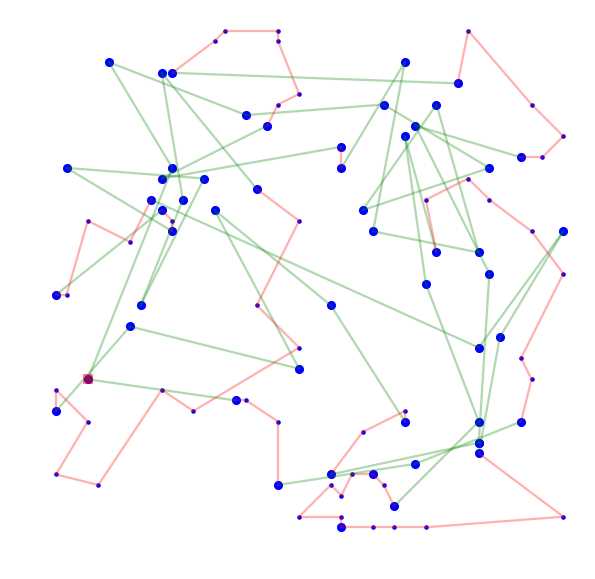

In [10]:
plt.figure(figsize=(10, 10))
tsp2.map_.plot_cities()
tsp2.map_.plot_tour(tsp2.best_solution)

Observations:
1. The solution is dominated by flights in this case.
2. There are many long paths among large cities, where flights are available.

The solution looks good and reasonable.

#### Problem 2.3

We keep the same initialization and cooling schedule; we change 2 thresholds in turn. We use the same random seed in each experiment.

#### 2.3.1 Optimization for the total distance

In [11]:
%%time

thres = [(3, 5), (30, 5), (10, 2), (10, 8)]
N = 100
tsp31 = []

def tf(T):
    return 0.9 * T

def itf(length):
    return int(np.ceil(1.2 * length))

print('Optimize for the total distance')
for t in thres:
    m = Map(N, dist_thres=t[0], pop_thres=t[1]).create_cities()

    ef = functools.partial(init_tour, m)

    pf = functools.partial(change_tour, m)

    inits = dict(solution=list(range(N)), length=100, T=80)
    epochs = 50
    
    print('Distance threshold {}, Population threshold {}'.format(t[0], t[1]))
    tsp31.append(SA_TSP(m, 0).run_sa(ef, inits, epochs, tf, itf, pf, verbose=False))

Optimize for the total distance
Distance threshold 3, Population threshold 5
Frac accepted 0.019436005237812862 Total iterations 4591993 Best meta {'index': 4238818, 'temp': 0.4581133517617881}
Distance threshold 30, Population threshold 5
Frac accepted 0.019436005237812862 Total iterations 4591993 Best meta {'index': 4238818, 'temp': 0.4581133517617881}
Distance threshold 10, Population threshold 2
Frac accepted 0.019436005237812862 Total iterations 4591993 Best meta {'index': 4238818, 'temp': 0.4581133517617881}
Distance threshold 10, Population threshold 8
Frac accepted 0.019436005237812862 Total iterations 4591993 Best meta {'index': 4238818, 'temp': 0.4581133517617881}
Wall time: 19min 18s


Wall time: 10.4 s


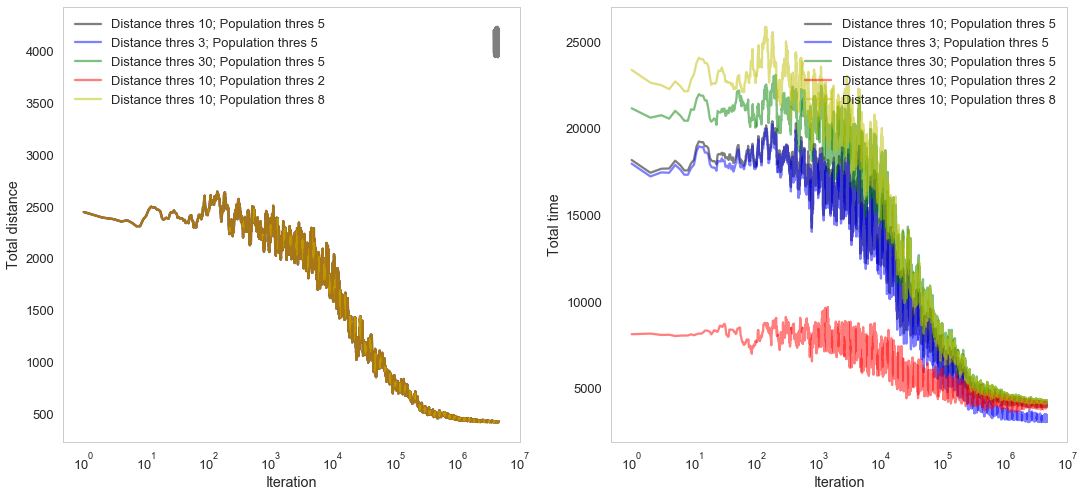

In [12]:
%%time

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)

colors = ['b', 'g', 'r', 'y']

for i_start, i_end in tsp1.T_index:
    if i_end != tsp1.T_index[-1][-1]:
        plt.plot(range(i_start + 1, i_end + 1), tsp1.accumulator[i_start:i_end, 0], \
                 alpha=0.5, color='k')
    else:
        plt.plot(range(i_start + 1, i_end + 1), tsp1.accumulator[i_start:i_end, 1], \
                 alpha=0.5, color='k', label='Distance thres {}; Population thres {}'.format(10, 5))
plt.xscale('log');
plt.xlabel('Iteration');
plt.ylabel('Total distance');

for i, tsp in enumerate(tsp31):
    for i_start, i_end in tsp.T_index:
        if i_end != tsp.T_index[-1][-1]:
            plt.plot(range(i_start + 1, i_end + 1), tsp.accumulator[i_start:i_end, 0], \
                     alpha=0.5, color=colors[i])
        else:
            plt.plot(range(i_start + 1, i_end + 1), tsp.accumulator[i_start:i_end, 0], \
                     alpha=0.5, color=colors[i], \
                     label='Distance thres {}; Population thres {}'.format(thres[i][0], thres[i][1]))

plt.legend();        

plt.subplot(1, 2, 2)
for i_start, i_end in tsp1.T_index:
    if i_end != tsp1.T_index[-1][-1]:
        plt.plot(range(i_start + 1, i_end + 1), tsp1.accumulator[i_start:i_end, 1], \
                 alpha=0.5, color='k')
    else:
        plt.plot(range(i_start + 1, i_end + 1), tsp1.accumulator[i_start:i_end, 1], \
                 alpha=0.5, color='k', label='Distance thres {}; Population thres {}'.format(10, 5))
plt.xscale('log');
plt.xlabel('Iteration');
plt.ylabel('Total time');

for i, tsp in enumerate(tsp31):
    for i_start, i_end in tsp.T_index:
        if i_end != tsp.T_index[-1][-1]:
            plt.plot(range(i_start + 1, i_end + 1), tsp.accumulator[i_start:i_end, 1], \
                     alpha=0.5, color=colors[i])
        else:
            plt.plot(range(i_start + 1, i_end + 1), tsp.accumulator[i_start:i_end, 1], \
                     alpha=0.5, color=colors[i], \
                     label='Distance thres {}; Population thres {}'.format(thres[i][0], thres[i][1]))

plt.legend(); 

The curves of total distance over iterations overlap, since we use the same random seed for each experiment. The curves of total time over iterations differ, since the available transportation for the same path might change.

Wall time: 790 ms


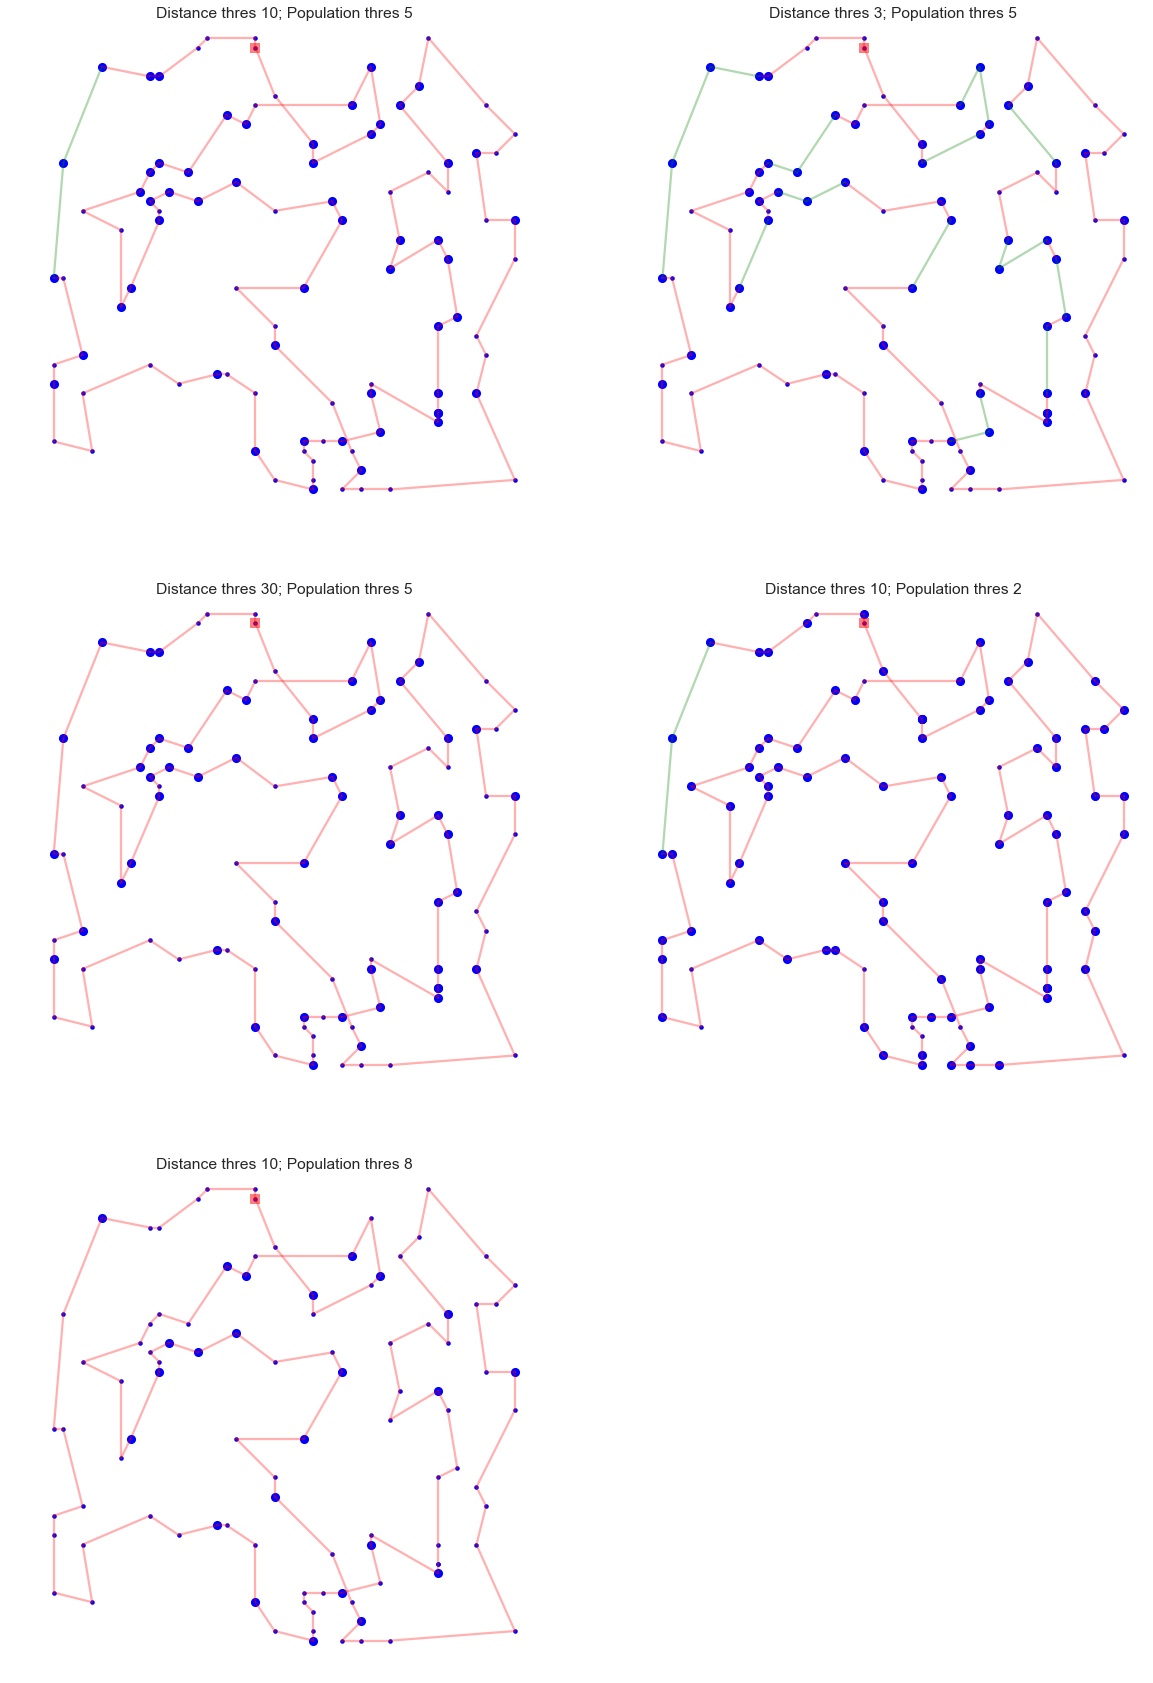

In [13]:
%%time

plt.figure(figsize=(20, 30))
plt.subplot(3, 2, 1)
tsp1.map_.plot_cities()
tsp1.map_.plot_tour(tsp1.best_solution)
plt.title('Distance thres {}; Population thres {}'.format(10, 5))

for i, tsp in enumerate(tsp31):
    plt.subplot(3, 2, i + 2)
    tsp.map_.plot_cities()
    tsp.map_.plot_tour(tsp.best_solution)
    plt.title('Distance thres {}; Population thres {}'.format(thres[i][0], thres[i][1]))

We get the same path in these cases, since the distance between 2 cities wouldn't change when we alter the distance and the population distance.

#### 2.3.2 Optimization for the total time

In [14]:
%%time

thres = [(3, 5), (30, 5), (10, 2), (10, 8)]
N = 100
tsp32 = []

def tf(T):
    return 0.9 * T

def itf(length):
    return int(np.ceil(1.2 * length))

print('Optimize for the total time')
for t in thres:
    m = Map(N, dist_thres=t[0], pop_thres=t[1]).create_cities()

    ef = functools.partial(init_tour, m)

    pf = functools.partial(change_tour, m)

    inits = dict(solution=list(range(N)), length=100, T=500)
    epochs = 50
    
    print('Distance threshold {}, Population threshold {}'.format(t[0], t[1]))
    tsp32.append(SA_TSP(m, 1).run_sa(ef, inits, epochs, tf, itf, pf, verbose=False))

Optimize for the total time
Distance threshold 3, Population threshold 5
Frac accepted 0.030566901996584055 Total iterations 4591993 Best meta {'index': 3873599, 'temp': 2.8632084485111777}
Distance threshold 30, Population threshold 5
Frac accepted 0.015264178320829321 Total iterations 4591993 Best meta {'index': 3992796, 'temp': 2.8632084485111777}
Distance threshold 10, Population threshold 2
Frac accepted 0.05196284053568897 Total iterations 4591993 Best meta {'index': 4039425, 'temp': 2.8632084485111777}
Distance threshold 10, Population threshold 8
Frac accepted 0.014901155119356671 Total iterations 4591993 Best meta {'index': 3490414, 'temp': 3.181342720567975}
Wall time: 19min 18s


Wall time: 10.3 s


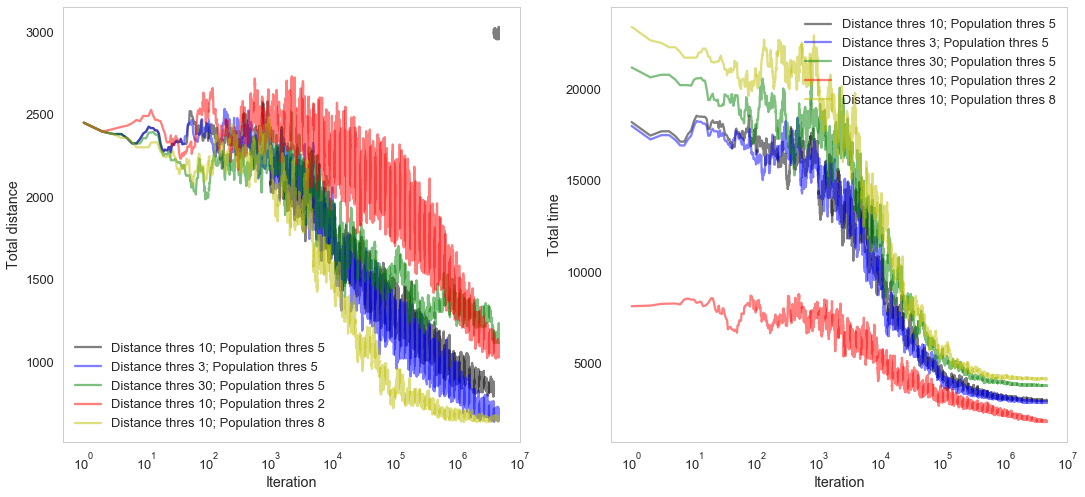

In [15]:
%%time

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)

colors = ['b', 'g', 'r', 'y']

for i_start, i_end in tsp2.T_index:
    if i_end != tsp2.T_index[-1][-1]:
        plt.plot(range(i_start + 1, i_end + 1), tsp2.accumulator[i_start:i_end, 0], \
                 alpha=0.5, color='k')
    else:
        plt.plot(range(i_start + 1, i_end + 1), tsp2.accumulator[i_start:i_end, 1], \
                 alpha=0.5, color='k', label='Distance thres {}; Population thres {}'.format(10, 5))
plt.xscale('log');
plt.xlabel('Iteration');
plt.ylabel('Total distance');

for i, tsp in enumerate(tsp32):
    for i_start, i_end in tsp.T_index:
        if i_end != tsp.T_index[-1][-1]:
            plt.plot(range(i_start + 1, i_end + 1), tsp.accumulator[i_start:i_end, 0], \
                     alpha=0.5, color=colors[i])
        else:
            plt.plot(range(i_start + 1, i_end + 1), tsp.accumulator[i_start:i_end, 0], \
                     alpha=0.5, color=colors[i], \
                     label='Distance thres {}; Population thres {}'.format(thres[i][0], thres[i][1]))

plt.legend();        

plt.subplot(1, 2, 2)
for i_start, i_end in tsp2.T_index:
    if i_end != tsp2.T_index[-1][-1]:
        plt.plot(range(i_start + 1, i_end + 1), tsp2.accumulator[i_start:i_end, 1], \
                 alpha=0.5, color='k')
    else:
        plt.plot(range(i_start + 1, i_end + 1), tsp2.accumulator[i_start:i_end, 1], \
                 alpha=0.5, color='k', label='Distance thres {}; Population thres {}'.format(10, 5))
plt.xscale('log');
plt.xlabel('Iteration');
plt.ylabel('Total time');

for i, tsp in enumerate(tsp32):
    for i_start, i_end in tsp.T_index:
        if i_end != tsp.T_index[-1][-1]:
            plt.plot(range(i_start + 1, i_end + 1), tsp.accumulator[i_start:i_end, 1], \
                     alpha=0.5, color=colors[i])
        else:
            plt.plot(range(i_start + 1, i_end + 1), tsp.accumulator[i_start:i_end, 1], \
                     alpha=0.5, color=colors[i], \
                     label='Distance thres {}; Population thres {}'.format(thres[i][0], thres[i][1]))

plt.legend(); 

Observations:
1. When we increase the distance threshold (and keep the same population threshold), both the total time and the total distance of the result increase.
2. When we decrease the distance threshold (and keep the same population threshold), the total time of the result doesn't seem to change much but the total distance decreases.
3. When we increase the population threshold (and keep the same distance threshold), the total time of the result increases and the total distance decreases. It is reasonable since there would be less flights and the salesman would have to drive more frequently; so it is better to pick up shorter paths.
4. When we decrease the population threshold (and keep the same distance threshold), the total time of the result decreases and the totla distance increases. The salesman would take more flights.

Wall time: 1.2 s


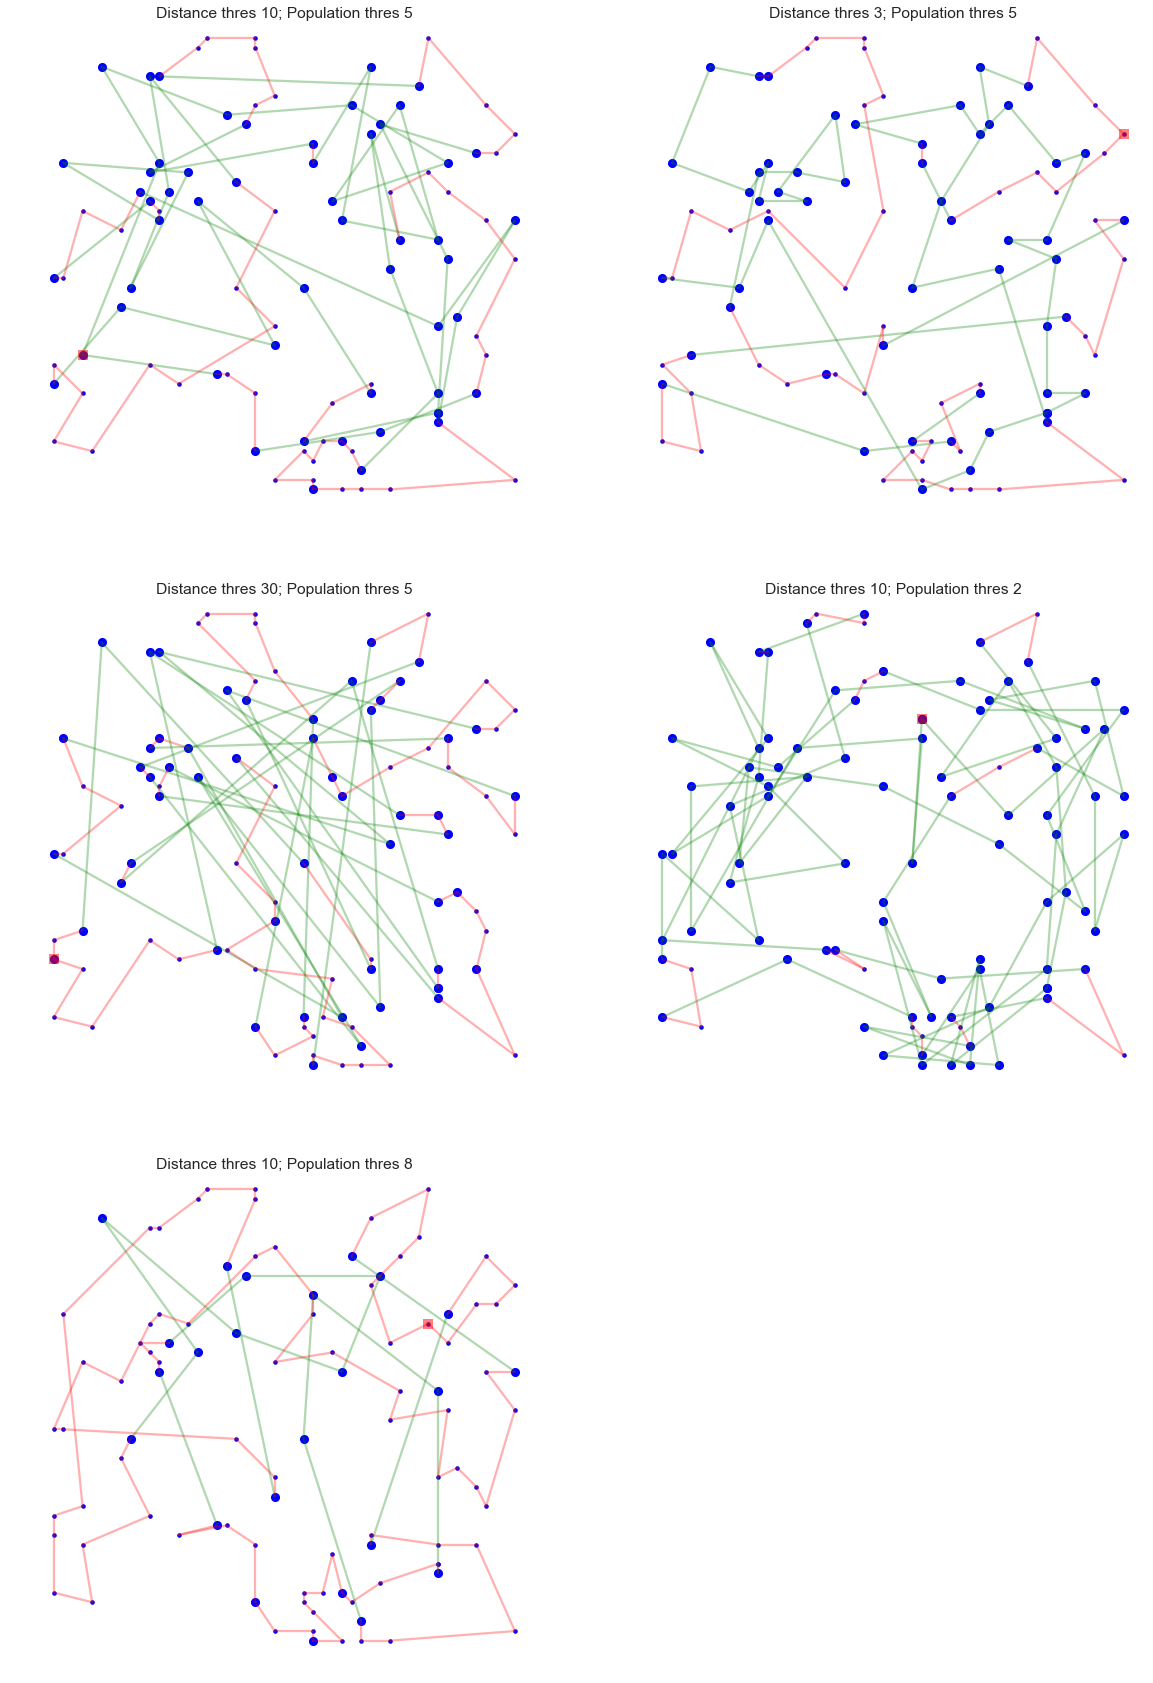

In [16]:
%%time

plt.figure(figsize=(20, 30))
plt.subplot(3, 2, 1)
tsp2.map_.plot_cities()
tsp2.map_.plot_tour(tsp2.best_solution)
plt.title('Distance thres {}; Population thres {}'.format(10, 5))

for i, tsp in enumerate(tsp32):
    plt.subplot(3, 2, i + 2)
    tsp.map_.plot_cities()
    tsp.map_.plot_tour(tsp.best_solution)
    plt.title('Distance thres {}; Population thres {}'.format(thres[i][0], thres[i][1]))

Observations:
1. When we increase the distance threshold (and keep the same population threshold), the result seems to be more tangled (more intersections) and there seem to be more long flights.
2. When we decrease the distance threshold (and keep the same population threshold), the result seems to be less tangled (less intersections).
3. When we increase the population threshold (and keep the same distance threshold), the result includes less long paths and there are less flights, presumably due to the decrease in the number of large cities.
4. When we decrease the population threshold (and keep the same distance threshold), there are more flights and the result seems to be more tangled (more intersections).